#### Project guidelines (comment to be removed)

https://github.com/suneman/socialdataanalysis2020/wiki/Final-Project


# Motivation.
merging Copenhagen traffic data with weather data to check if traffic volumes can be predicted over time and space


### What is your dataset?
* This dataset contains hourly data about some of the busiest roads in Copenhagen that is available from this oppen data page: 
https://www.opendata.dk/city-of-copenhagen/faste-trafiktaellinger#resource-faste_trafikt%C3%A6llinger_2008.xlsx


* The data reported are the total number of vehicles observed on these roads on each hour for all calendar days on each of the relevant roads


* Then for the weather we gathered data from.....


### Why did you choose this/these particular dataset(s)?
We thought it could be interesting to invesigate patterns in the data and try to forecast traffic volumes when we add weather data

### What was your goal for the end user's experience?
Building a tool that allows users to easily visualize the data in space and time and understand how thes traffic volumes/flows distribute across different timeframes, spaces/neighboroughs and weather conditions




# Basic stats. Let's understand the dataset better


### Write about your choices in data cleaning and preprocessing
We have deleted all the empty and oterwise irrelavant columns of data
Then we created new features, mostly time references that we will need to visualize the data by different time references: daily, weekly, yearly, etc.




In [2]:
!pip install --upgrade geopandas

     |████████████████████████████████| 1.0MB 8.1MB/s 
     |████████████████████████████████| 6.5MB 27.4MB/s 
     |████████████████████████████████| 14.8MB 305kB/s 


In [3]:
import geopandas as gp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Downloading data and removing/adding features

In [19]:
# Downloading faste-trafiktaellinger-2008_clean (to be changed if we get data directly form website)
df = pd.read_csv('https://raw.githubusercontent.com/LarsBryld/socialdata/main/faste-trafiktaellinger-2008_clean.csv', parse_dates = ["Dato"], dayfirst=True, encoding='latin-1')

# removing the Spor and Vej-Id columns
df = df.drop(columns = ['Spor', 'Vej-Id'])

# Add Day of the Week, Day, ,Week, Month, Year,
df["DayName"] = df['Dato'].apply(lambda x: x.day_name())
df["WeekDay"] = df['Dato'].dt.weekday
df["DayOfMonth"] = df['Dato'].dt.day
df["Week"] = df['Dato'].dt.week
df["Month"] = df['Dato'].dt.month
df["Year"] = df['Dato'].dt.year

#clean up the "Longitude"
df = df.rename(columns={'(UTM32)': 'Easting', '(UTM32).1': 'Northing'})

#change the Hours headers
for i in range(4,28):
    df = df.rename(columns={df.columns[i]: df.columns[i].split('.')[1].split('-')[0]})
    df[df.columns[i]] = df[df.columns[i]].str.replace(',', '').fillna(0).astype('int')

df['TotalDailyVehicles'] = df.iloc[:,4:28].sum(axis=1)

df.head(3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  # This is added back by InteractiveShellApp.init_path()


,Vejnavn,Easting,Northing,Dato,00,01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20,21,22,23,DayName,WeekDay,DayOfMonth,Week,Month,Year,TotalDailyVehicles
0,Ellebjergvej,720881,6172777,2008-01-01,188,306,346,255,175,156,153,127,104,100,188,345,457,588,662,728,607,539,481,397,314,253,241,163,Tuesday,1,1,1,1,2008,7873
1,Ellebjergvej,720881,6172777,2008-01-02,70,59,58,82,128,478,1038,1428,1200,964,958,992,1016,1014,1000,1164,1189,911,746,482,394,316,316,200,Wednesday,2,2,1,1,2008,16203
2,Ellebjergvej,720881,6172777,2008-01-03,96,80,51,77,141,502,1161,1513,1398,1202,1049,1062,1069,1001,1049,1304,1233,1088,744,495,381,361,315,237,Thursday,3,3,1,1,2008,17609


### Write a short section that discusses the dataset stats, containing key points/plots from your exploratory data analysis.


Below is the Total Count of vehicles per Road in descending order recorded in the whole period and a barplot that allows the visualization of the data.
From both the list and the plot below you can see how there are significant differences in traffic volumes among the roads chosen in the dataset

In [20]:
totcount = df.groupby('Vejnavn')['TotalDailyVehicles'].sum().sort_values(ascending=False)
pd.DataFrame(totcount.values, index = list(totcount.index), columns =['Total Vehicles']) 

,Total Vehicles
Fredensbro,29044400
Kalvebod Brygge,28326756
Åboulevard,25158122
Ellebjergvej,24868666
Hareskovvej,23991308
Tuborgvej,21336624
Torvegade,21168919
Vigerslev Allé,15960134
Frederikssundsvej,15680518
Jagtvej,14724056


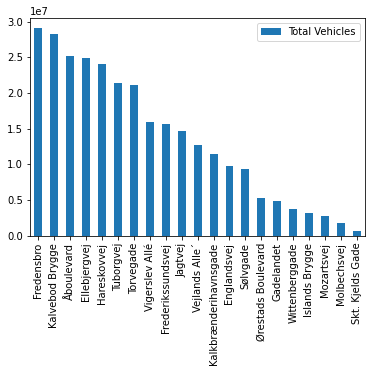

In [22]:
pd.DataFrame(totcount.values, index = list(totcount.index), columns =['Total Vehicles']).plot.bar()

# Let's look at how the data distribute across time
## Weekly distribution of total vehicles

The main pattern observable is the w-e drop in traffic

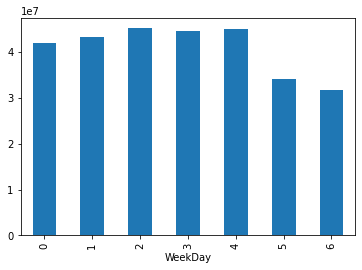

In [23]:
df.groupby('WeekDay')['TotalDailyVehicles'].sum().plot.bar()

## Weekly distribution per Road
From the plots below a clear drop of traffic on all roads is clearly visible.
2 main exceptions to this pattern are:
* **Kalvebod Brygge** where the drop happens on Mondays and tuesdays. Althought this could be due to some quality issue about the data (we need to check if this is still the case when we include all years (now we are only working with 2008 data)
* **Jagtvej** shows a much lower drop in the w-e compared to other roads


In [24]:
w = df.groupby(["WeekDay", "Vejnavn"]).sum()["TotalDailyVehicles"].unstack()


Vejnavn,Ellebjergvej,Englandsvej,Fredensbro,Frederikssundsvej,Gadelandet,Hareskovvej,Islands Brygge,Jagtvej,Kalkbrænderihavnsgade,Kalvebod Brygge,Molbechsvej,Mozartsvej,Skt. Kjelds Gade,Sølvgade,Torvegade,Tuborgvej,Vejlands Alle´,Vigerslev Allé,Wittenberggade,Åboulevard,Ørestads Boulevard
WeekDay,,,,,,,,,,,,,,,,,,,,,
0,3766282,1448420,4396864,2290688,746782,3694174,501996,2096956,1774680,3059130,294589,390592,94532,1429338,3090238,3332452,1927130,2412912,563470,3794542,819164
1,3951004,1479752,4627718,2356882,777744,3891538,524470,2175348,1876718,2640692,301398,403418,97860,1517864,3222342,3507654,2011040,2500602,578947,4025316,817704
2,3955852,1486238,4659302,2345146,781468,3868028,526446,2197992,1904532,4403214,304384,402260,97178,1527568,3234102,3522200,2024608,2523092,579956,3944298,806110
3,3888430,1471296,4612854,2327278,757746,3830448,521496,2185678,1856190,4527500,291673,392918,98606,1503620,3231832,3442748,1992274,2469710,562732,3863840,774448
4,3931934,1500296,4572998,2413298,773946,3815806,510692,2164348,1842246,4587632,279635,408252,94104,1494650,3255407,3308764,2017414,2509480,601604,3931774,835828
5,2829888,1203832,3229572,2096344,536076,2490586,283656,1998212,1098414,4506696,172510,351890,69630,960918,2601070,2137658,1491534,1863140,482548,2908084,699628
6,2545276,1122152,2945092,1850882,456876,2400728,263406,1905522,1052955,4601892,145550,328974,66692,839612,2533928,2085148,1284562,1681198,354984,2690268,446278


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2db472cc10>,
      dtype=object)

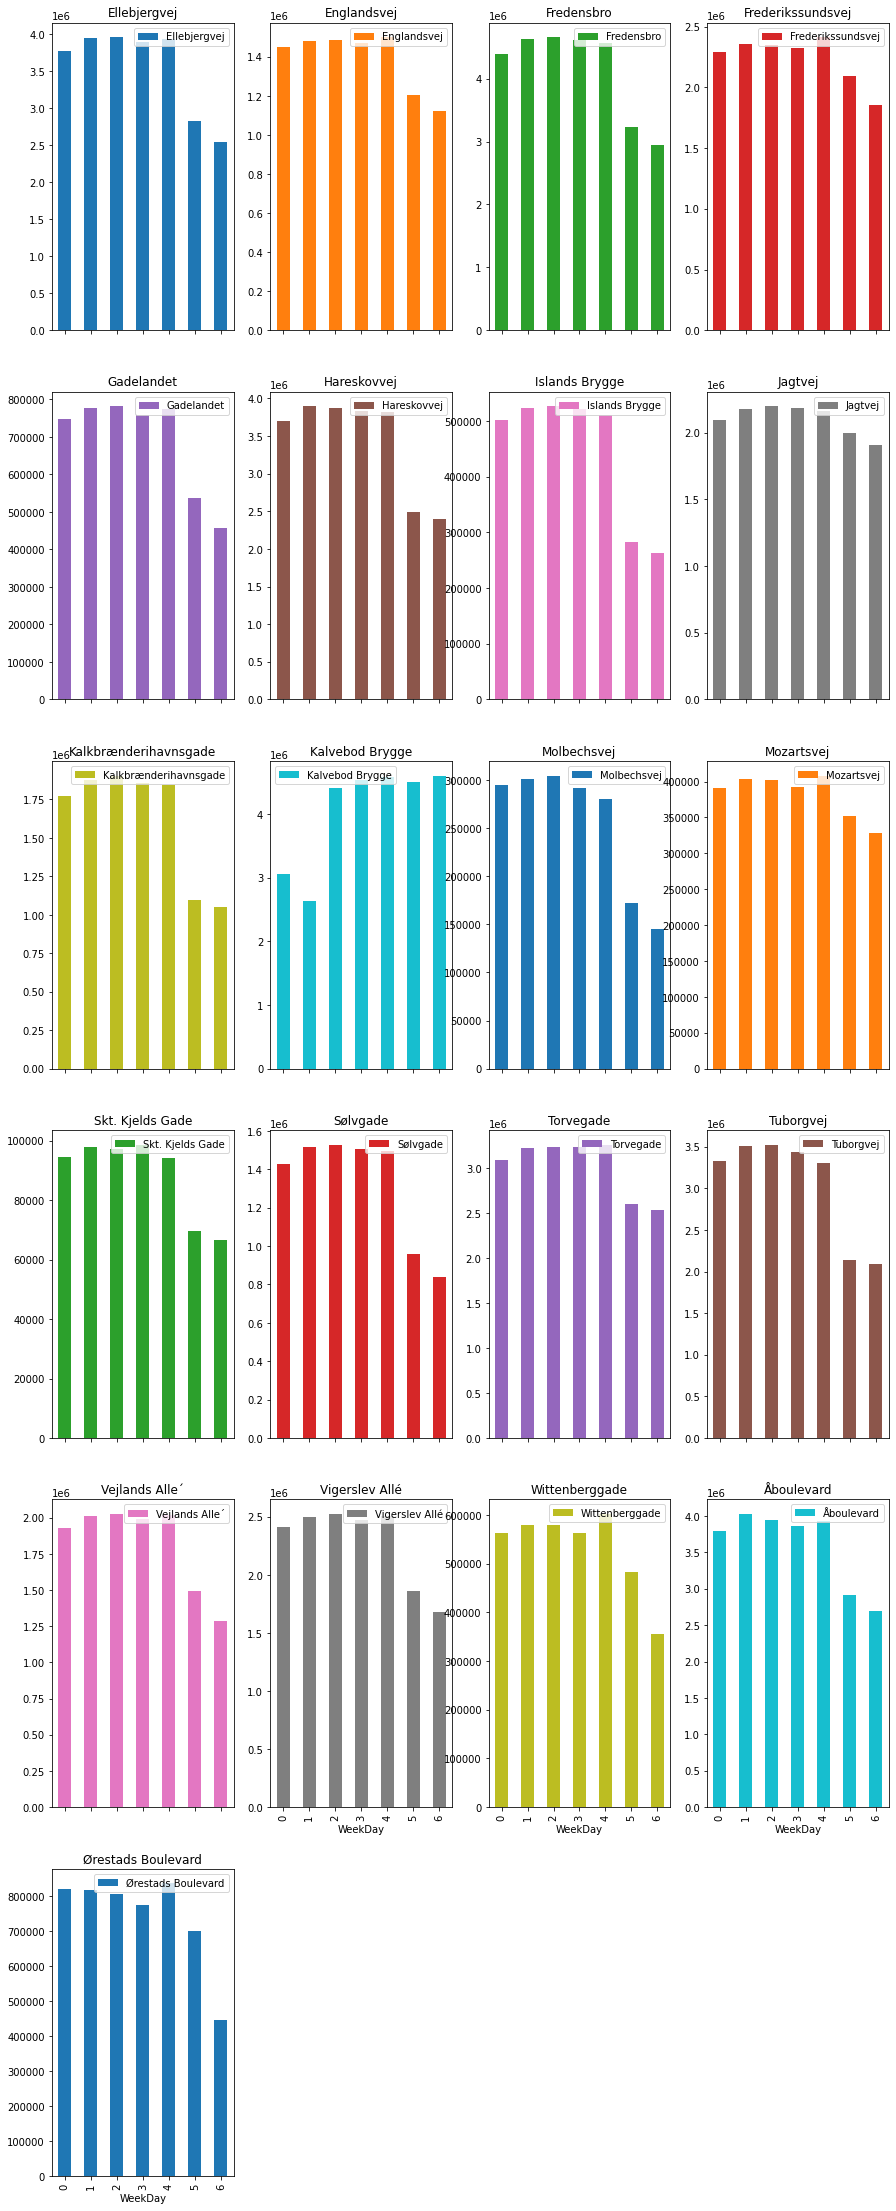

In [25]:
w.plot(kind='bar', subplots=True, figsize=(15,60), layout=(9,4))

## Montly distribution per Road
* The main feature that is clearly visible is the drop in taffic on nearly all roads on July, which is the month where most Copenhageners are on holidays away from the city
* a few roads that except these rule show unclear patterns that could be due to data quality issues (check if this is true after wi enclose other years

In [26]:
m = df.groupby(["Month", "Vejnavn"]).sum()["TotalDailyVehicles"].unstack()


Vejnavn,Ellebjergvej,Englandsvej,Fredensbro,Frederikssundsvej,Gadelandet,Hareskovvej,Islands Brygge,Jagtvej,Kalkbrænderihavnsgade,Kalvebod Brygge,Molbechsvej,Mozartsvej,Skt. Kjelds Gade,Sølvgade,Torvegade,Tuborgvej,Vejlands Alle´,Vigerslev Allé,Wittenberggade,Åboulevard,Ørestads Boulevard
Month,,,,,,,,,,,,,,,,,,,,,
1,2060364.0,637070.0,2426394.0,1411336.0,419202.0,NaN,270232.0,1221552.0,1003328.0,1910744.0,153223.0,221122.0,64740.0,821894.0,1743644.0,1808428.0,1061592.0,1312260.0,322354.0,696022.0,442836.0
2,1992526.0,797780.0,2307864.0,1319912.0,402010.0,NaN,259520.0,1183154.0,979247.0,2264944.0,134324.0,216050.0,60590.0,768712.0,1697794.0,1737678.0,1063210.0,1243920.0,305380.0,2594610.0,422948.0
3,1524920.0,833482.0,2315168.0,1384276.0,399636.0,52294.0,254600.0,1239488.0,978840.0,2280026.0,143947.0,219828.0,43426.0,758274.0,1764614.0,1733110.0,1057672.0,1268134.0,312480.0,1881888.0,425626.0
4,2190420.0,890540.0,2462088.0,1395954.0,425462.0,2776270.0,272702.0,1250836.0,1096708.0,2378702.0,207550.0,226872.0,64450.0,816710.0,1841118.0,1898446.0,1086168.0,1322952.0,316332.0,2766366.0,429388.0
5,2200408.0,891964.0,2457046.0,1415540.0,427138.0,2802176.0,283830.0,1250724.0,1077740.0,2466354.0,154237.0,241322.0,66902.0,797072.0,1898664.0,1883144.0,1076474.0,1327768.0,315488.0,2742448.0,423384.0
6,2136640.0,881110.0,2421586.0,1339968.0,398370.0,2731184.0,280774.0,1214386.0,1051042.0,2462206.0,137394.0,225096.0,64956.0,776084.0,1848550.0,1812478.0,1064986.0,1363206.0,306520.0,2694392.0,423098.0
7,1972876.0,827678.0,2048664.0,1197162.0,341440.0,2319328.0,241004.0,1102132.0,957048.0,2287830.0,121076.0,214008.0,46920.0,614834.0,1685844.0,1512400.0,933966.0,1192130.0,275112.0,2237040.0,379666.0
8,2157024.0,684886.0,2356760.0,1354118.0,386148.0,2596104.0,262076.0,1262848.0,1048600.0,2608786.0,141982.0,219810.0,65974.0,733610.0,1798235.0,1761024.0,1106084.0,1349872.0,301206.0,1534942.0,460822.0
9,2183526.0,867722.0,2462280.0,1369952.0,415384.0,2801828.0,267464.0,1253244.0,990526.0,2440416.0,167284.0,218308.0,70388.0,784606.0,1762042.0,1862106.0,1112686.0,1395652.0,306107.0,1194656.0,429678.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2db3117c50>,
      dtype=object)

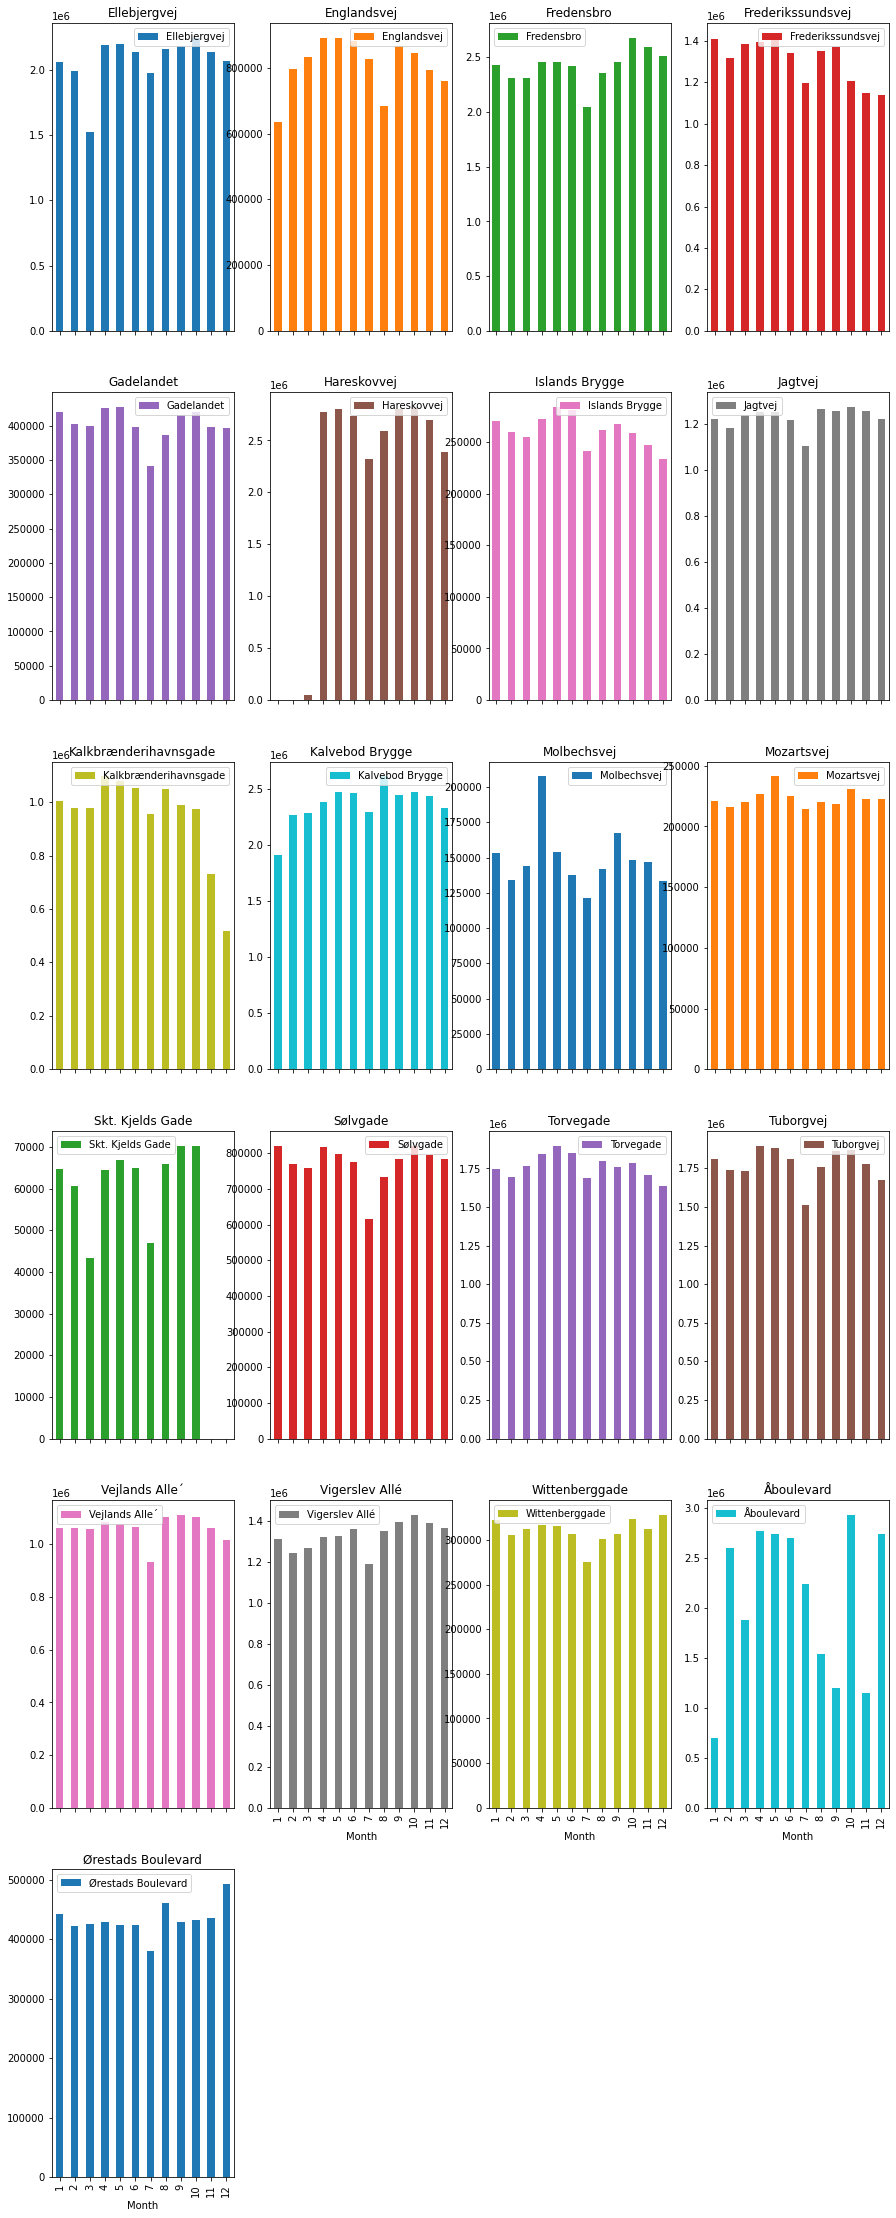

In [27]:
m.plot(kind='bar', subplots=True, figsize=(15,60), layout=(9,4))

## Day of the month distribution per Road
one pattern that can be observed is that the 31st day of the month shows a little more than half the volumes of the average of the other days. This is probably due to the fact that there are ony 7 months that contain 31 days

In [29]:
d = df.groupby(["DayOfMonth", "Vejnavn"]).sum()["TotalDailyVehicles"].unstack()


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2db0f9d790>,
      dtype=object)

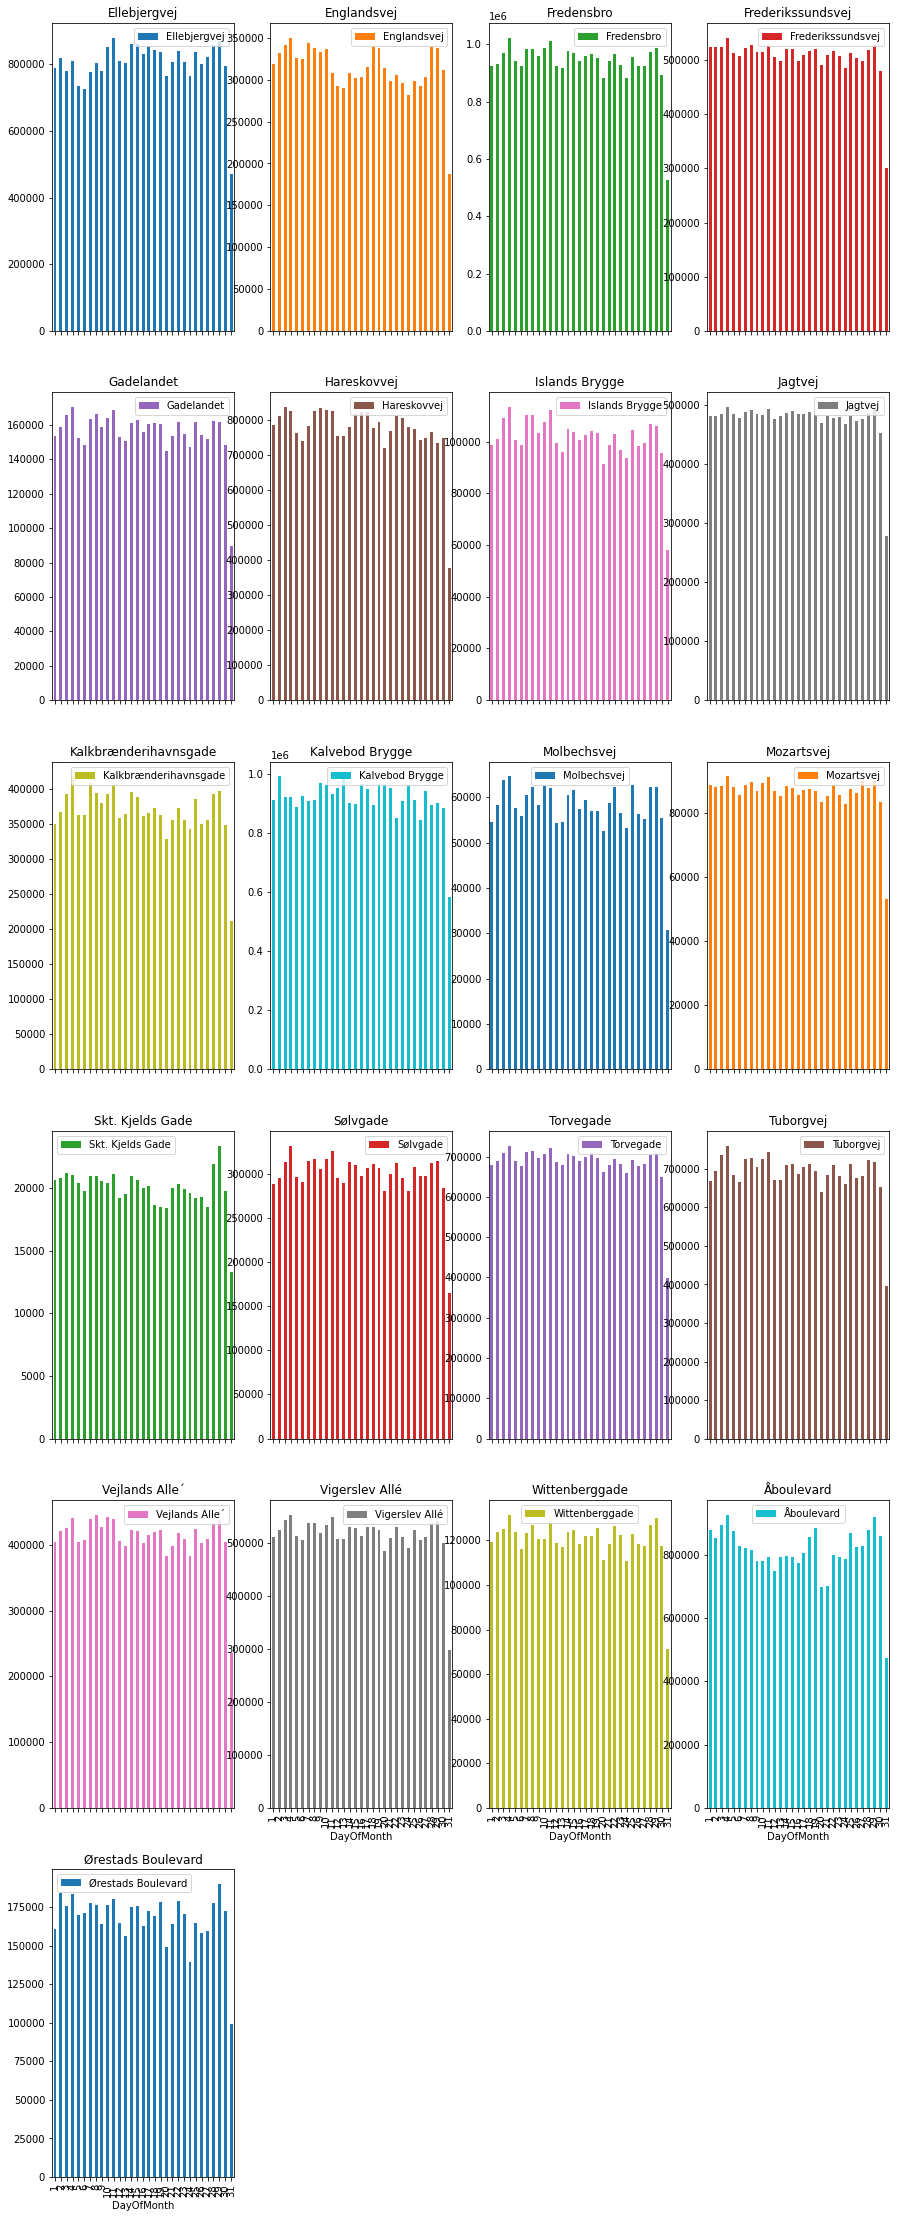

In [30]:
d.plot(kind='bar', subplots=True, figsize=(15,60), layout=(9,4))

* Yearly